# FeatureEngineer_ImpactAnalysis「特征工程 + 影响分析」

In [5]:
# !pip install shap

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from pathlib import Path
from io import StringIO
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import shap

warnings.filterwarnings("ignore")

# Set font and graphic styles
plt.rcParams["font.sans-serif"] = ["DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
sns.set_style("whitegrid")

### Load data

In [7]:
def load_aqhi_csv(path):
    """Load single CSV file"""
    with open(path, "r", encoding="utf-8-sig") as f:
        lines = f.readlines()
    header_idx = next(
        i for i, line in enumerate(lines) if line.strip().startswith("Date")
    )
    csv_data = "".join(lines[header_idx:])
    df = pd.read_csv(StringIO(csv_data))

    # Remove asterisks and convert to numeric
    station_columns = df.columns[2:]
    for col in station_columns:
        df[col] = df[col].astype(str).str.replace("*", "", regex=False)
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Handle dates and hours
    df["Date"] = df["Date"].ffill()
    df["Hour"] = pd.to_numeric(df["Hour"], errors="coerce")
    df["Hour"] = df["Hour"].ffill()
    df = df.dropna(subset=["Hour"])
    df["Hour"] = df["Hour"].astype(int)

    # Remove daily max rows
    df = df[df["Hour"] != "Daily Max"]

    # Create datetime
    def adjust_hour_to_datetime(date_str, hour_int):
        if hour_int == 24:
            date_obj = pd.to_datetime(date_str) + timedelta(days=1)
            return date_obj.replace(hour=0, minute=0, second=0)
        else:
            return pd.to_datetime(f"{date_str} {hour_int:02d}:00:00")

    df["DateTime"] = df.apply(
        lambda row: adjust_hour_to_datetime(row["Date"], row["Hour"]), axis=1
    )

    return df


def load_aqhi_data():
    """Load and preprocess AQHI data"""
    data_dir = Path("Datasets")
    monthly_files = [
        "202501_Eng.csv",
        "202502_Eng.csv",
        "202503_Eng.csv",
        "202504_Eng.csv",
        "202505_Eng.csv",
    ]

    monthly_dfs = []
    for fname in monthly_files:
        file_path = data_dir / fname
        if file_path.exists():
            df_month = load_aqhi_csv(file_path)
            monthly_dfs.append(df_month)
        else:
            print(f"Warning: {fname} not found. Skipping.")

    all_df = pd.concat(monthly_dfs, ignore_index=True)
    return all_df

In [8]:
print("Loading data...")
df = load_aqhi_data()
print(f"Initial data shape: {df.shape}")
df.head()

Loading data...
Initial data shape: (3775, 21)


,Date,Hour,Central/Western,Southern,Eastern,Kwun Tong,Sham Shui Po,Kwai Chung,Tsuen Wan,Tseung Kwan O,...,Tuen Mun,Tung Chung,Tai Po,Sha Tin,North,Tap Mun,Causeway Bay,Central,Mong Kok,DateTime
0,2025-01-01,1,6.0,6,6.0,6.0,5.0,5.0,5,6.0,...,5.0,4.0,5.0,5.0,5.0,5.0,5.0,6.0,5.0,2025-01-01 01:00:00
1,2025-01-01,2,7.0,6,5.0,5.0,5.0,5.0,5,5.0,...,5.0,5.0,5.0,6.0,5.0,5.0,5.0,6.0,5.0,2025-01-01 02:00:00
2,2025-01-01,3,7.0,5,5.0,5.0,5.0,5.0,5,5.0,...,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2025-01-01 03:00:00
3,2025-01-01,4,6.0,5,5.0,5.0,5.0,5.0,5,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2025-01-01 04:00:00
4,2025-01-01,5,5.0,5,5.0,5.0,5.0,5.0,5,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2025-01-01 05:00:00


### Feature Engineer: Time Feature

In [18]:
def create_time_features(df):
    """Create time-based features"""
    # Basic time features
    df["hour_of_day"] = df["DateTime"].dt.hour
    df["day_of_week"] = df["DateTime"].dt.dayofweek
    df["month"] = df["DateTime"].dt.month
    df["day_of_month"] = df["DateTime"].dt.day
    df["day_of_year"] = df["DateTime"].dt.dayofyear

    # Time period features
    df["is_weekend"] = (df["DateTime"].dt.dayofweek >= 5).astype(int)

    # Time period bins based on EDA analysis
    time_bins = [0, 6, 8, 17, 20, 24]  # Based on hourly pattern analysis
    time_labels = ["Night", "Morning_Rush", "Daytime", "Evening_Rush", "Night_Late"]
    df["time_period"] = pd.cut(
        df["hour_of_day"], bins=time_bins, labels=time_labels, include_lowest=True
    )

    # Seasonal features - 修复重复标签问题
    # 方案1: 重新定义季节划分（推荐）
    season_bins = [0, 2, 5, 8, 11]  # Winter: 1-2, Spring: 3-5, Summer: 6-8, Fall: 9-11
    season_labels = ["Winter", "Spring", "Summer", "Fall"]
    df["season"] = pd.cut(
        df["month"], bins=season_bins, labels=season_labels, include_lowest=True
    )

    # Peak hour indicator (based on EDA finding: 17:00 is peak)
    df["is_peak_hour"] = ((df["hour_of_day"] >= 16) & (df["hour_of_day"] <= 18)).astype(
        int
    )

    return df

### Feature Engineer: SpaceFeature

In [19]:
def create_spatial_features(df):
    """Create spatial and station grouping features"""
    station_columns = [
        "Central/Western",
        "Southern",
        "Eastern",
        "Kwun Tong",
        "Sham Shui Po",
        "Kwai Chung",
        "Tsuen Wan",
        "Tseung Kwan O",
        "Yuen Long",
        "Tuen Mun",
        "Tung Chung",
        "Tai Po",
        "Sha Tin",
        "North",
        "Tap Mun",
        "Causeway Bay",
        "Central",
        "Mong Kok",
    ]

    # High correlation groups based on EDA
    df["urban_core_avg"] = df[["Central/Western", "Central", "Mong Kok"]].mean(axis=1)
    df["eastern_group_avg"] = df[["Eastern", "Kwun Tong", "Sham Shui Po"]].mean(axis=1)
    df["new_territories_avg"] = df[["Yuen Long", "Tuen Mun", "Tai Po"]].mean(axis=1)

    # Tap Mun as special feature (low correlation with others)
    df["tap_mun_relative"] = df["Tap Mun"] - df[station_columns].mean(axis=1)

    # Spatial statistics
    df["spatial_mean"] = df[station_columns].mean(axis=1)
    df["spatial_std"] = df[station_columns].std(axis=1)
    df["spatial_max"] = df[station_columns].max(axis=1)
    df["spatial_min"] = df[station_columns].min(axis=1)
    df["spatial_range"] = df["spatial_max"] - df["spatial_min"]

    # Pollution level indicators
    df["high_pollution_count"] = (df[station_columns] > 6).sum(axis=1)
    df["very_high_pollution_count"] = (df[station_columns] > 8).sum(axis=1)
    df["any_station_high"] = (df[station_columns] > 7).any(axis=1).astype(int)

    return df, station_columns

### 特征工程函数: 统计特征

In [20]:
def create_statistical_features(df, station_columns):
    """Create rolling statistics and change features"""

    # Sort by datetime for rolling features
    df = df.sort_values("DateTime").reset_index(drop=True)

    # Rolling statistics for key stations (select a few representative ones)
    key_stations = ["Central/Western", "Eastern", "Tap Mun", "Tsuen Wan"]

    for station in key_stations:
        for window in [3, 6, 12, 24]:  # 3h, 6h, 12h, 24h windows
            df[f"{station}_rolling_mean_{window}h"] = (
                df[station].rolling(window=window, min_periods=1).mean()
            )
            df[f"{station}_rolling_std_{window}h"] = (
                df[station].rolling(window=window, min_periods=1).std()
            )
            df[f"{station}_rolling_max_{window}h"] = (
                df[station].rolling(window=window, min_periods=1).max()
            )

    # Change rates
    for station in key_stations:
        df[f"{station}_hourly_change"] = df[station].diff()
        df[f"{station}_daily_change"] = df[station].diff(24)
        df[f"{station}_change_3h_avg"] = df[station].diff(3)

    # Overall rolling statistics
    df["overall_rolling_mean_6h"] = (
        df[station_columns].mean(axis=1).rolling(window=6, min_periods=1).mean()
    )
    df["overall_rolling_std_6h"] = (
        df[station_columns].mean(axis=1).rolling(window=6, min_periods=1).std()
    )

    # Lag features
    for lag in [1, 3, 6, 24]:  # 1h, 3h, 6h, 24h lags
        df[f"overall_lag_{lag}h"] = df[station_columns].mean(axis=1).shift(lag)

    return df

### 特征工程函数 - 目标变量

In [21]:
def create_target_variables(df, station_columns):
    """Create target variables for prediction"""

    # Overall average as primary target
    df["target_current"] = df[station_columns].mean(axis=1)

    # Future prediction targets
    df["target_3h_ahead"] = df[station_columns].mean(axis=1).shift(-3)
    df["target_6h_ahead"] = df[station_columns].mean(axis=1).shift(-6)
    df["target_24h_ahead"] = df[station_columns].mean(axis=1).shift(-24)

    # Peak prediction target
    df["target_next_peak"] = df[station_columns].max(axis=1).shift(-24)

    # Classification target
    conditions = [
        df[station_columns].mean(axis=1) <= 3,
        (df[station_columns].mean(axis=1) > 3)
        & (df[station_columns].mean(axis=1) <= 6),
        df[station_columns].mean(axis=1) > 6,
    ]
    choices = [0, 1, 2]  # 0: Low, 1: Medium, 2: High
    df["pollution_level"] = np.select(conditions, choices)

    return df

### 执行特征工程

In [22]:
print("Creating features...")

# Time features
df = create_time_features(df)
print("Time features created")

# Spatial features
df, station_columns = create_spatial_features(df)
print("Spatial features created")

# Statistical features
df = create_statistical_features(df, station_columns)
print("Statistical features created")

# Target variables
df = create_target_variables(df, station_columns)
print("Target variables created")

print(f"Final data shape after feature engineering: {df.shape}")
print(
    f"Number of features: {len([col for col in df.columns if not col.startswith('target_')])}"
)

# 显示创建的特征
print("\nCreated feature categories:")
time_features = [
    col
    for col in df.columns
    if any(x in col for x in ["hour", "day", "weekend", "month", "season", "peak"])
]
spatial_features = [
    col
    for col in df.columns
    if any(x in col for x in ["avg", "relative", "spatial", "pollution"])
]
statistical_features = [
    col
    for col in df.columns
    if any(x in col for x in ["rolling", "change", "lag", "std"])
]

print(f"Time features: {len(time_features)}")
print(f"Spatial features: {len(spatial_features)}")
print(f"Statistical features: {len(statistical_features)}")

Creating features...
Time features created
Spatial features created
Statistical features created
Target variables created
Final data shape after feature engineering: (3775, 114)
Number of features: 109

Created feature categories:
Time features: 13
Spatial features: 16
Statistical features: 67


### 建模准备函数

In [23]:
def prepare_model_data(df, target_column="target_current"):
    """Prepare data for modeling"""

    # Select feature columns (exclude datetime and target columns)
    exclude_cols = [
        "DateTime",
        "Date",
        "Hour",
        "target_current",
        "target_3h_ahead",
        "target_6h_ahead",
        "target_24h_ahead",
        "target_next_peak",
        "pollution_level",
    ]

    feature_columns = [
        col
        for col in df.columns
        if col not in exclude_cols and not col.startswith("target_")
    ]

    # Handle categorical variables
    df_encoded = pd.get_dummies(df, columns=["time_period", "season"], drop_first=True)

    # Update feature columns after encoding
    feature_columns = [
        col
        for col in df_encoded.columns
        if col not in exclude_cols and not col.startswith("target_")
    ]

    # Remove rows with missing target
    model_df = df_encoded.dropna(subset=[target_column])

    X = model_df[feature_columns]
    y = model_df[target_column]

    return X, y, feature_columns

### 模型训练和评估函数「随机森林回归模型」

In [24]:
def train_and_evaluate_model(X, y, test_size=0.2, random_state=42):
    """Train Random Forest model and evaluate performance"""

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = RandomForestRegressor(
        n_estimators=100, random_state=random_state, n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Model Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return model, X_train_scaled, X_test_scaled, y_train, y_test, scaler, X.columns

### 特征影响分析函数

In [25]:
def feature_impact_analysis(model, X_test, feature_names, X_train=None):
    """Comprehensive feature impact analysis using SHAP"""

    print("\n=== FEATURE IMPACT ANALYSIS ===")

    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Global feature importance
    feature_importance = pd.DataFrame(
        {"feature": feature_names, "importance": np.abs(shap_values).mean(0)}
    ).sort_values("importance", ascending=False)

    print("\nTop 20 Most Important Features:")
    print(feature_importance.head(20).to_string(index=False))

    # Categorize features
    time_features = [
        f
        for f in feature_names
        if any(x in f for x in ["hour", "day", "weekend", "month", "season", "peak"])
    ]
    spatial_features = [
        f
        for f in feature_names
        if any(x in f for x in ["avg", "relative", "spatial", "pollution"])
    ]
    statistical_features = [
        f
        for f in feature_names
        if any(x in f for x in ["rolling", "change", "lag", "std"])
    ]

    # Calculate category impacts
    time_impact = feature_importance[feature_importance["feature"].isin(time_features)][
        "importance"
    ].sum()
    spatial_impact = feature_importance[
        feature_importance["feature"].isin(spatial_features)
    ]["importance"].sum()
    statistical_impact = feature_importance[
        feature_importance["feature"].isin(statistical_features)
    ]["importance"].sum()

    print(f"\nFeature Category Impacts:")
    print(
        f"Time Features: {time_impact:.4f} ({time_impact/feature_importance['importance'].sum()*100:.1f}%)"
    )
    print(
        f"Spatial Features: {spatial_impact:.4f} ({spatial_impact/feature_importance['importance'].sum()*100:.1f}%)"
    )
    print(
        f"Statistical Features: {statistical_impact:.4f} ({statistical_impact/feature_importance['importance'].sum()*100:.1f}%)"
    )

    return shap_values, feature_importance

### 可视化函数

In [28]:
def plot_impact_analysis(shap_values, X_test, feature_names, feature_importance):
    """Create visualization for impact analysis"""

    # 1. SHAP Summary Plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title("SHAP Feature Impact Summary", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()

    # 2. Feature Importance Bar Plot
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features["importance"])
    plt.yticks(range(len(top_features)), top_features["feature"])
    plt.xlabel("SHAP Importance")
    plt.title("Top 15 Most Important Features", fontsize=16, fontweight="bold")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # 3. Feature Category Impact
    categories = ["Time", "Spatial", "Statistical", "Other"]
    time_mask = [
        any(x in f for x in ["hour", "day", "weekend", "month", "season", "peak"])
        for f in feature_importance["feature"]
    ]
    spatial_mask = [
        any(x in f for x in ["avg", "relative", "spatial", "pollution"])
        for f in feature_importance["feature"]
    ]
    statistical_mask = [
        any(x in f for x in ["rolling", "change", "lag", "std"])
        for f in feature_importance["feature"]
    ]
    other_mask = [
        not (t or s or st)
        for t, s, st in zip(time_mask, spatial_mask, statistical_mask)
    ]

    category_impacts = [
        feature_importance[time_mask]["importance"].sum(),
        feature_importance[spatial_mask]["importance"].sum(),
        feature_importance[statistical_mask]["importance"].sum(),
        feature_importance[other_mask]["importance"].sum(),
    ]

    plt.figure(figsize=(10, 6))
    plt.pie(category_impacts, labels=categories, autopct="%1.1f%%", startangle=90)
    plt.title("Feature Impact by Category", fontsize=16, fontweight="bold")
    plt.show()

### 准备建模数据

In [29]:
print("Preparing modeling data...")
X, y, feature_names = prepare_model_data(df, target_column="target_current")
print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
print(f"Feature names (first 10): {feature_names[:10]}")

Preparing modeling data...
Features: 110, Samples: 3775
Feature names (first 10): ['Central/Western', 'Southern', 'Eastern', 'Kwun Tong', 'Sham Shui Po', 'Kwai Chung', 'Tsuen Wan', 'Tseung Kwan O', 'Yuen Long', 'Tuen Mun']


### 模型训练

In [30]:
print("Training model...")
model, X_train, X_test, y_train, y_test, scaler, feature_names = (
    train_and_evaluate_model(X, y)
)

Training model...
Model Performance:
RMSE: 0.0156
R2 Score: 0.9999


### 特征影响分析

In [31]:
print("Performing impact analysis...")
shap_values, feature_importance = feature_impact_analysis(
    model, X_test, feature_names, X_train
)

Performing impact analysis...

=== FEATURE IMPACT ANALYSIS ===

Top 20 Most Important Features:
                  feature  importance
             spatial_mean    1.055532
              spatial_std    0.000695
                Kwun Tong    0.000274
Tsuen Wan_rolling_mean_3h    0.000271
              spatial_max    0.000210
                  Eastern    0.000210
               Kwai Chung    0.000202
very_high_pollution_count    0.000187
          Central/Western    0.000151
Tsuen Wan_rolling_std_12h    0.000137
   Tap Mun_rolling_max_6h    0.000136
                    North    0.000132
              spatial_min    0.000129
            Tseung Kwan O    0.000110
         tap_mun_relative    0.000093
   Eastern_rolling_max_6h    0.000086
  Eastern_rolling_mean_3h    0.000077
     high_pollution_count    0.000070
                Tsuen Wan    0.000065
                  Central    0.000061

Feature Category Impacts:
Time Features: 0.0001 (0.0%)
Spatial Features: 1.0571 (99.7%)
Statistical Featu

### 创建可视化

Creating visualizations...


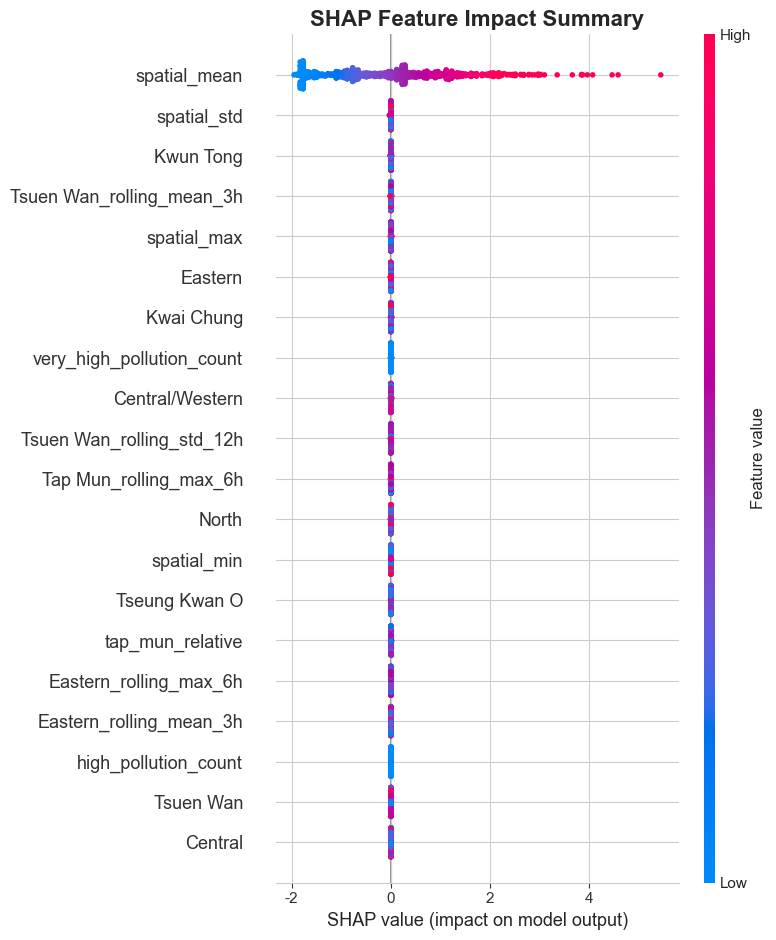

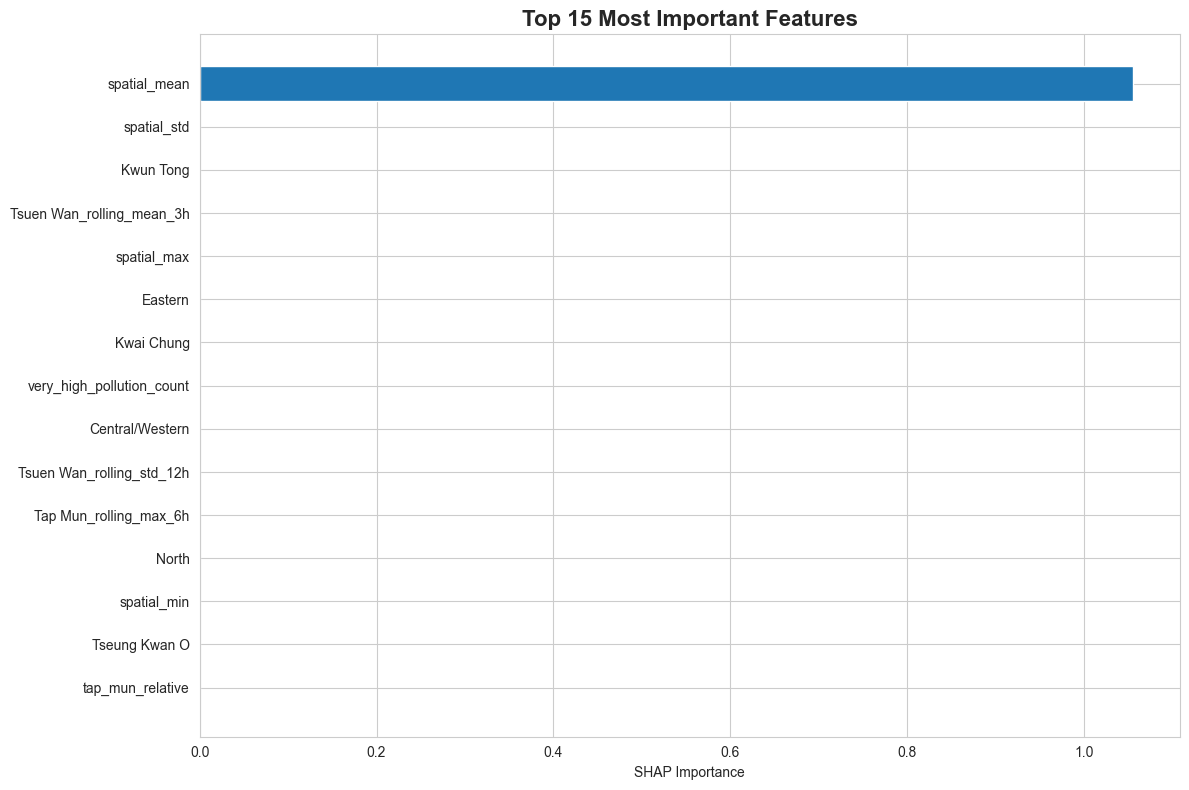

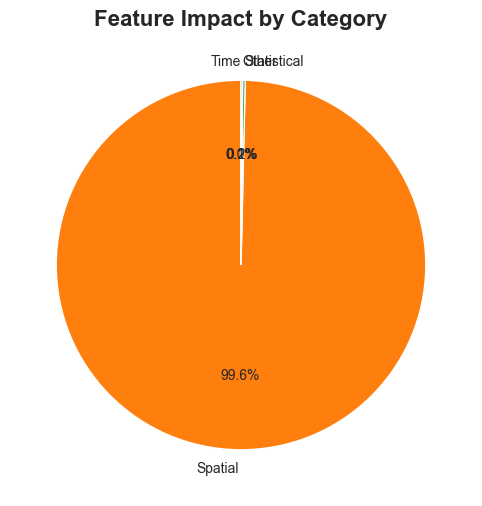

In [32]:
print("Creating visualizations...")
plot_impact_analysis(shap_values, X_test, feature_names, feature_importance)

### 总结

In [37]:
print("\n=== FEATURE ENGINEERING SUMMARY ===")
print(f"Total features created: {len(feature_names)}")

# 修复括号不匹配问题
time_feature_count = len(
    [
        f
        for f in feature_names
        if any(x in f for x in ["hour", "day", "weekend", "month", "season", "peak"])
    ]
)
spatial_feature_count = len(
    [
        f
        for f in feature_names
        if any(x in f for x in ["avg", "relative", "spatial", "pollution"])
    ]
)
statistical_feature_count = len(
    [
        f
        for f in feature_names
        if any(x in f for x in ["rolling", "change", "lag", "std"])
    ]
)

print(f"Time features: {time_feature_count}")
print(f"Spatial features: {spatial_feature_count}")
print(f"Statistical features: {statistical_feature_count}")

# 保存结果以便后续使用
results = {
    "df": df,
    "model": model,
    "feature_importance": feature_importance,
    "X_test": X_test,
    "y_test": y_test,
    "feature_names": feature_names,
    "shap_values": shap_values,
}

print("\nAll analysis completed successfully!")


=== FEATURE ENGINEERING SUMMARY ===
Total features created: 110
Time features: 14
Spatial features: 15
Statistical features: 67

All analysis completed successfully!
